## Preparing the Dataset

In [1]:
!nvidia-smi

Wed Aug 25 13:32:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
from PIL import Image
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms,models,datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import sklearn
from sklearn.utils import shuffle
import os
import cv2
!pip install torch_summary
from torchsummary import summary
! pip install kaggle

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download omkargurav/face-mask-dataset

 91% 149M/163M [00:01<00:00, 129MB/s]
100% 163M/163M [00:01<00:00, 138MB/s]


In [ ]:
! unzip face-mask-dataset.zip

In [8]:
Images=[]
Class=[]
Val_Images=[]
Val_Class=[]

In [9]:
source_dr = '/content/data/with_mask/'
for count, filename in enumerate(os.listdir(source_dr)):
  path=os.path.join(source_dr, filename)
  img=(cv2.imread(path)[:,:,::-1])
  img=cv2.resize(img, (224, 224))
  if (count<3500):
    Images.append(img)
    Class.append([0])
  elif (count>=3500 and count<3725):
    Val_Images.append(img)
    Val_Class.append([0])

In [10]:
source_dr = '/content/data/without_mask/'
for count, filename in enumerate(os.listdir(source_dr)):
  path=os.path.join(source_dr, filename)
  img=(cv2.imread(path)[:,:,::-1])
  img=cv2.resize(img, (224, 224))
  if (count<3500):
    Images.append(img)
    Class.append([1])
  elif (count>=3500 and count<3725):
    Val_Images.append(img)
    Val_Class.append([1])

In [11]:
Images=np.array(Images)
Val_Images=np.array(Val_Images)

In [12]:
print(Images.shape)
print(Val_Images.shape)

(7000, 224, 224, 3)
(450, 224, 224, 3)


In [13]:
Images=shuffle(Images, random_state=0)
Class=shuffle(Class, random_state=0)
Val_Images=shuffle(Val_Images, random_state=0)
Val_Class=shuffle(Val_Class, random_state=0)

[0]


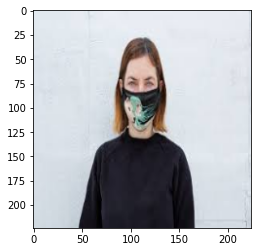

In [14]:
print(Class[0])
plt.imshow(Images[0])

[1]


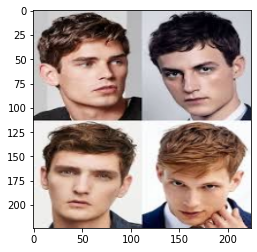

In [15]:
print(Val_Class[420])
plt.imshow(Val_Images[420])

In [16]:
from numpy import moveaxis
from numpy import asarray

In [17]:
Tr_Images=[]
for i in range(0, 7000):
  img=Images[i]
  data=asarray(img)
  data = moveaxis(data, 2, 0)
  Tr_Images.append(data)

Tr_Images=np.array(Tr_Images)

In [18]:
VImages=[]
for i in range(0, 450):
  img=Val_Images[i]
  data=asarray(img)
  data = moveaxis(data, 2, 0)
  VImages.append(data)

VImages=np.array(VImages)

In [19]:
print(Tr_Images.shape)
print(VImages.shape)

(7000, 3, 224, 224)
(450, 3, 224, 224)


In [20]:
class Mask_Detect(Dataset):
    def __init__(self, x, y):
        self.x=x
        self.y=y
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    def __len__(self):
        return len(self.x)
    def __getitem__(self, ix):
        x=self.x[ix]
        x=torch.tensor(x/255)
        x=self.normalize(x)
        y=self.y[ix]
        y=torch.tensor(y)
        return x.float().to(device), y.float().to(device)

In [21]:
def get_model():
  model=models.vgg16(pretrained=True)
  for param in model.parameters():
    param.requires_grad=False
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.classifier = nn.Sequential(nn.Flatten(),
                                   nn.Linear(512, 100),
                                   nn.ReLU(),
                                   nn.Dropout(0.3),
                                   nn.Linear(100, 1),
                                   nn.Sigmoid())
  loss_fn=nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
  return model.to(device), loss_fn, optimizer

In [22]:
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [23]:
def train_batch(x, y, model, optimizer, loss_fn):
  model.train()
  prediction=model(x)
  batch_loss=loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [24]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()

In [25]:
@torch.no_grad()
def value_loss(x, y, model, loss_fn):
  model.eval()
  prediction=model(x)
  val_loss=loss_fn(prediction, y)
  return val_loss.item()

In [26]:
def get_data():
    train = Mask_Detect(Tr_Images, Class)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = Mask_Detect(VImages, Val_Class)
    val_dl = DataLoader(val, batch_size=32, shuffle=True)
    return trn_dl, val_dl

In [27]:
train_loss, train_accuracy=[], [] #For training
val_loss, val_accuracy=[], [] #For evaluation
train_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
for epoch in range(3):
    batch_losses_in_epoch, batch_accuracy_epoch=[], []  #For training
    val_batch_losses_in_epoch, val_batch_accuracy_epoch=[], []  #For evaluation
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        is_correct = accuracy(x, y, model)
        batch_losses_in_epoch.append(batch_loss)
        batch_accuracy_epoch.extend(is_correct)
    mean_batch_loss=np.mean(batch_losses_in_epoch)
    epoch_accuracy=np.mean(batch_accuracy_epoch)
    train_loss.append(mean_batch_loss)
    train_accuracy.append(epoch_accuracy)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_batch_loss = value_loss(x, y, model, loss_fn)
        is_correct = accuracy(x, y, model)
        val_batch_losses_in_epoch.append(val_batch_loss)
        val_batch_accuracy_epoch.extend(is_correct)
    mean_batch_loss=np.mean(val_batch_losses_in_epoch)
    epoch_accuracy_1=np.mean(val_batch_accuracy_epoch)
    val_loss.append(mean_batch_loss)
    val_accuracy.append(epoch_accuracy_1)

    print("Epoch : " , epoch ,", Train_Accuracy : " ,epoch_accuracy ,", Test_Accuracy : " ,epoch_accuracy_1)

Epoch :  0 , Train_Accuracy :  0.9728571428571429 , Test_Accuracy :  0.9888888888888889
Epoch :  1 , Train_Accuracy :  0.9944285714285714 , Test_Accuracy :  0.9888888888888889
Epoch :  2 , Train_Accuracy :  0.9964285714285714 , Test_Accuracy :  0.9888888888888889


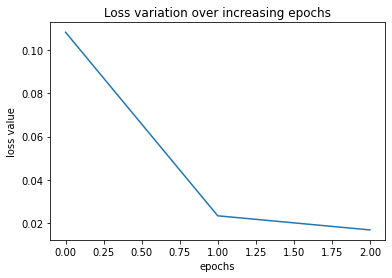

In [28]:
plt.plot(train_loss)
plt.title('Loss variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.show()

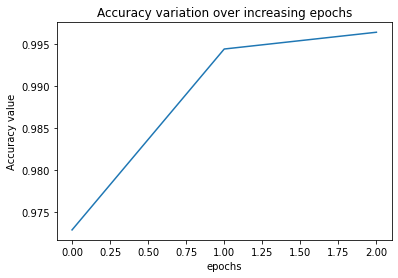

In [29]:
plt.plot(train_accuracy)
plt.title('Accuracy variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('Accuracy value')
plt.show()

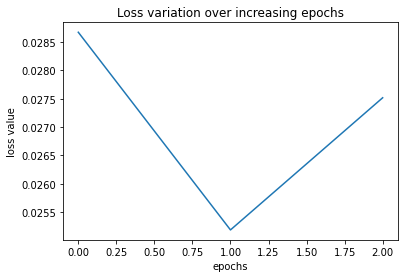

In [30]:
plt.plot(val_loss)
plt.title('Loss variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.show()

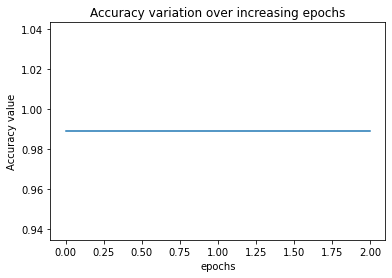

In [31]:
plt.plot(val_accuracy)
plt.title('Accuracy variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('Accuracy value')
plt.show()

## Prediction

[[0.9999509]]


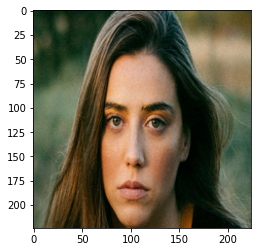

In [47]:
img1=Image.open('/content/No_Mask_2.jpg')
img1=img1.resize((224, 224))
data=asarray(img1)
data=moveaxis(data, 2, 0)
img2=torch.tensor(data/255).view(-1, 3, 224, 224).float().to(device)
TF=transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
img2=TF(img2)
np_output=model(img2)
np_output=np_output.detach().cpu().numpy()
print(np_output)
plt.imshow(img1)

[[3.7173746e-07]]


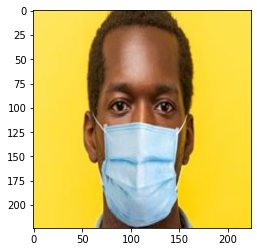

In [48]:
img1=Image.open('/content/Wearing_Mask_1.jpg')
img1=img1.resize((224, 224))
data=asarray(img1)
data=moveaxis(data, 2, 0)
img2=torch.tensor(data/255).view(-1, 3, 224, 224).float().to(device)
TF=transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
img2=TF(img2)
np_output=model(img2)
np_output=np_output.detach().cpu().numpy()
print(np_output)
plt.imshow(img1)

In [49]:
torch.save(model.to('cpu').state_dict(), 'Mask_Detector.pth')